In [1]:
import logging
import os
import time
import warnings
from functools import partial  # for pd.Series.map(ztfs)
from multiprocessing.pool import Pool
from pathlib import Path

import cartopy.crs as ccrs
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import G211
from lightning import ztfs

from ml_functions import brier_skill_score, get_args, get_flash_pred
from spc import get_issuance_time
from statisticplot import stat_plots

sns.set_theme()

logging.basicConfig(level=logging.WARNING, format="%(asctime)s %(message)s", force=True)
tmpdir = Path(os.getenv("TMPDIR"))

2024-02-28 11:29:54.542503: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 11:29:54.575211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
# map projection
map_crs = G211.g211
grid = G211.grid
grid = grid.to_crs(ccrs.PlateCarree())

conus_mask = G211.mask

### Load SPC enhanced tstm outlook
downloaded by [get_enhtstm.ipynb](get_enhtstm.ipynb)


In [4]:
tmpdir = Path(os.getenv("TMPDIR"))
sfiles = (tmpdir / "enhtstm").glob("????/*.zip")
sfiles = sorted(sfiles)
column = "DN"

sfiles[0].name, sfiles[-1].name, len(sfiles)

('enh00_20200101_012000_202001010525-shp.zip',
 'enh20_20230630_301600_202306301252-shp.zip',
 15426)

In [54]:
obsvar = "cg.ic"
o_thresh = 1
twin = 4
rptdist = 20
clobber = False

platform = "glm" if obsvar == "flashes" else "wbug"

f = f"{obsvar}_{rptdist}km_{twin}hr"
# Define observation/probability thresholds
thresh = pd.Series([o_thresh], name=f"{obsvar} threshold")
pthresh = pd.Series([10, 40, 70], name=f"fcst prob\nthresh") / 100.0
args = get_args(o_thresh, twin)
args

Namespace(batchnorm=True, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=30, labels=['cg_20km_4hr', 'ic_20km_4hr', 'cg.ic_20km_4hr', 'flashes_20km_4hr', 'cg_40km_4hr', 'ic_40km_4hr', 'cg.ic_40km_4hr', 'flashes_40km_4hr'], fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=1, folds=None, kfold=1, idate=None, ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='Adam', reg_penalty=0.0, savedmodel='/glade/work/ahijevyc/NSC_objects/nn/lightning/001+.4hr', seed=-1, trainstart=Timestamp('2019-10-02 00:00:00'), trainend=Timestamp('2020-12-02 00:00:00'), teststart=Timestamp('2020-12-02 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), twin=4, suite='default')

In [55]:
def spc_forecast_obs(sfile: str):
    """
    get forecast valid start and end from sfile string
    return (forecast, observations) tuple from same period
    """

    assert twin > 1, "no DNN time windows for twin == 1"

    f = geopandas.read_file(sfile).to_crs(ccrs.PlateCarree())
    record = os.path.basename(sfile)

    issue, valid_start, valid_end = get_issuance_time(record)
    logging.info(f"{issue} {valid_start} {valid_end}")

    # Get observations from DataFrame from ml_functions.load_df()
    # instead of lightning.get_obs()
    # so you have the same data, and don't "repeat" the same
    # function with different code.
    # get_obs allows GLM or WxBug to be missing for a time
    # but load_df does not.

    # Uses `obs` DataFrame already sliced from Y DataFrame outside function.

    valid_times = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )
    # if all expected valid_times are available
    if all(
        [
            valid_time in obs.index.get_level_values("valid_time")
            for valid_time in valid_times
        ]
    ):
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            # Reduce initialization_time dimension for multiple
            # initialization_times that have the same valid_time.
            # The validation data, obs, are the same for each init time so just
            # take the first.
            o = (
                obs.loc[
                    (slice(None), slice(None), slice(None), valid_times),
                    args.labels,
                ]
                .groupby(["x", "y", "valid_time"])
                .first()
            )
        o = o.groupby(["x", "y"]).sum()  # sum valid times
    else:
        return None

    # Assign value to conus grid points within polygons
    f = grid[conus_mask.values.ravel()].sjoin(f, how="left")

    f["record"] = record
    f["issue"] = issue
    # convert to str avoids TypeError: Object of type Timestamp is not JSON serializable
    # when saving to parquet
    f["valid_start"] = valid_start.strftime("%Y%m%d %H:%M")
    f["valid_end"] = valid_end.strftime("%Y%m%d %H:%M")
    columns = ["record", "DN", "issue", "valid_start", "valid_end"]
    # fill missing fcst prob (outside any polygon) with 0. Join with obs.
    f = f[columns].fillna(0).join(o)
    f = f.set_index("record", append=True)

    return f

### Load DataFrame of DNN forecasts / observations

In [56]:
# get observations from DNN forecast/obs DataFrame
Y = get_flash_pred(args, clobber=clobber)

# ensmean of fits and folds
# Don't be clever by subtracting {"fit", "fold"} set from Y.index.names
# Order of returned list of levels was random. valid_time did not always come 2nd.
levels = ["initialization_time", "valid_time", "y", "x", "forecast_hour", "lat", "lon"]
logging.warning(f"groupby {levels} for ensmean")
ensmean = Y.groupby(level=levels).mean()

# obs used in spc_forecast_obs() defined above
logging.warning("obs (label) slice")
obs = ensmean.xs("y_label", axis="columns", level=0)

2024-02-28 13:45:03,959 read saved model output /glade/derecho/scratch/ahijevyc/tmp/Y.001+4hr.2020-12-02 00:00:00-2022-01-01 00:00:00.par
2024-02-28 13:45:36,638 done
2024-02-28 13:45:36,657 groupby ['initialization_time', 'valid_time', 'y', 'x', 'forecast_hour', 'lat', 'lon'] for ensmean
2024-02-28 13:46:21,254 obs (label) slice


## Verify SPC enhanced tstm forecast

### Match obs to each SPC forecast in parallel

In [57]:
ffile = tmpdir / f"spc_fcst.{twin}hr.par"

if not clobber and os.path.exists(ffile):  # and os.path.exists(ofile):
    logging.warning(f"read {ffile} {os.path.getsize(ffile)/1e6:.1f}M ")
    spc_fcst = pd.read_parquet(ffile)
else:
    logging.warning(f"make new file {ffile}")
    if twin == 2:
        logging.warning("Sure u want to compare DNNs with 2-hour time window to SPC?")

    assert obs.cg_40km_4hr.sum() > 0, (
        "no lightning obs. did you run cells further down that changed"
        " obs and then come back"
        " to this cell?"
    )

    # Use multiple cpus (like 16) and 60+GB memory.
    # 16 cpu, 89 GB, 16 processes took 17 minutes (twin=4)
    with Pool(processes=20) as pool:
        result = pool.map(
            spc_forecast_obs,
            tqdm(sfiles),
        )

    spc_fcst = pd.concat([x for x in result if x is not None])
    spc_fcst.to_parquet(ffile)

# tried saving this to parquet ofile but tuple in column broke arrow engine
spc_fcst["prodid"] = list(
    zip(
        spc_fcst.issue,
        pd.to_datetime(spc_fcst.valid_start).dt.hour,
        pd.to_datetime(spc_fcst.valid_end).dt.hour,
    )
)

logging.info("trim spc_fcst to testing range of neural network")
before_trim = len(spc_fcst)
spc_fcst = spc_fcst[
    (pd.to_datetime(spc_fcst.valid_start) >= pd.to_datetime(args.teststart))
    & (pd.to_datetime(spc_fcst.valid_end) <= pd.to_datetime(args.testend))
]
logging.warning(
    f"kept {len(spc_fcst)}/{before_trim} ({len(spc_fcst)/before_trim:%}) spc fcsts"
)

assert "enh00_20211231_312000_202112310559-shp.zip" in spc_fcst.index.get_level_values(
    "record"
)

2024-02-28 13:46:21,639 read /glade/derecho/scratch/ahijevyc/tmp/spc_fcst.4hr.par 4.1M 
2024-02-28 13:46:29,254 kept 6058656/6058656 (100.000000%) spc fcsts


[('0600', 12, 16)] [383] 0.1094
[('0600', 16, 20)] [357] 0.1347
[('1300', 16, 20)] [412] 0.1698
[('0600', 20, 0)] [362] 0.2808
[('1300', 20, 0)] [403] 0.2921
[('1700', 20, 0)] [396] 0.3146
[('1300', 0, 4)] [380] 0.1947
[('1700', 0, 4)] [389] 0.2254
[('2100', 0, 4)] [398] 0.2463
[('1700', 4, 12)] [374] 0.1656
[('2100', 4, 12)] [397] 0.1954
[('0130', 4, 12)] [381] 0.2575


2024-02-28 13:46:49,097 /glade/derecho/scratch/ahijevyc/tmp/enhtstm.001+cg.ic_20km.png


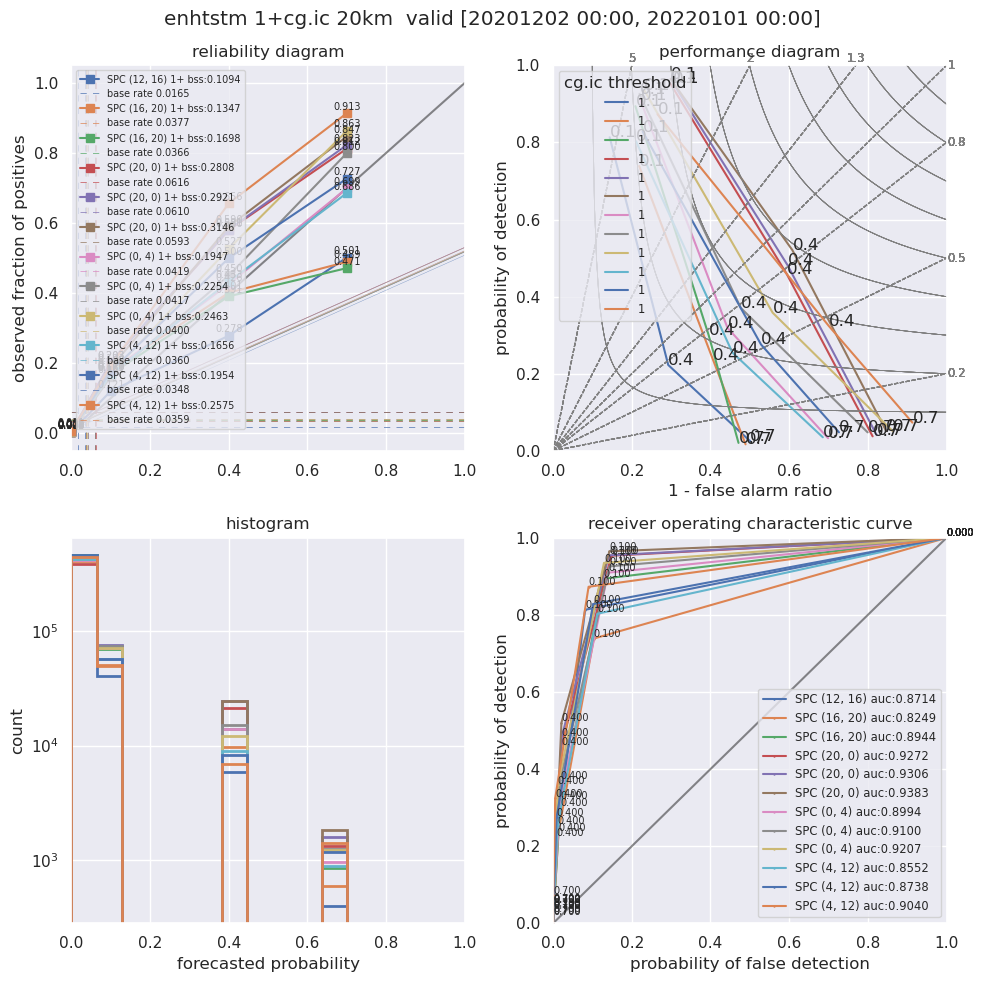

In [58]:
def valid_hour_str(prodids):
    valid_hour_range = prodids[0][1:]  # last 2 elements of first prodids tuple
    same_valid_hour_range = len(set([x[1:] for x in prodids])) == 1
    if same_valid_hour_range:
        return " " + str(valid_hour_range)
    return ""


fcst = spc_fcst
fcst = fcst.DN / 100

prodidss = [
    [("0600", 12, 16)],
    [("0600", 16, 20)],
    [("0600", 20, 0)],
]

# Aggregate by valid time
prodidss = [
    [("0600", 12, 16)],
    [("0600", 16, 20), ("1300", 16, 20)],
    [("0600", 20, 0), ("1300", 20, 0), ("1700", 20, 0)],
    [("1300", 0, 4), ("1700", 0, 4), ("2100", 0, 4)],
    [("1700", 4, 12), ("2100", 4, 12), ("0130", 4, 12)],
]

# Flatten list of lists to get every issuance and valid time in its own list
prodidss = [[x] for prodid in prodidss for x in prodid]
# All together
# prodidss = [[x for prodid in prodidss for x in prodid]]

ncols, nrows = 2, 2
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))
title = ""


spc_bss = {}
for prodids in prodidss:
    logging.info(f"forecast products for {len(prodids)} prodids")
    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()
    #print(ihr.sum() / 1308)

    # 1308 CONUS points per forecast
    cnt = (spc_fcst[ihr].groupby("prodid").size() / 1308).astype(int)

    print(cnt.index.values, cnt.values, end=" ")

    title += "  ".join([f"{c}{v}" for c, v in list(zip(cnt, cnt.index))])

    thisf = fcst[ihr]
    thisf.name = "SPC" + valid_hour_str(prodids)

    fig = stat_plots(
        spc_fcst.loc[ihr, f],
        thisf,
        thresh=thresh,
        pthresh=pthresh,
        o_thresh_roc=o_thresh,
        sep=0.01,
        n_bins=11,
        fig=fig,
    )
    if len(prodids) == 1:
        # Remember this for later
        spc_bss[prodids[0]] = brier_skill_score(spc_fcst.loc[ihr,f]>=o_thresh, thisf)

title = f"enhtstm {o_thresh}+{obsvar} {rptdist}km"
title += f"  valid [{spc_fcst.valid_start.min()}, {spc_fcst.valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()
ofile = tmpdir / f"enhtstm.{o_thresh:03d}+{obsvar}_{rptdist}km.png"
plt.savefig(ofile)
logging.warning(ofile)

2024-02-28 13:46:50,900 /glade/derecho/scratch/ahijevyc/tmp/cnt.png


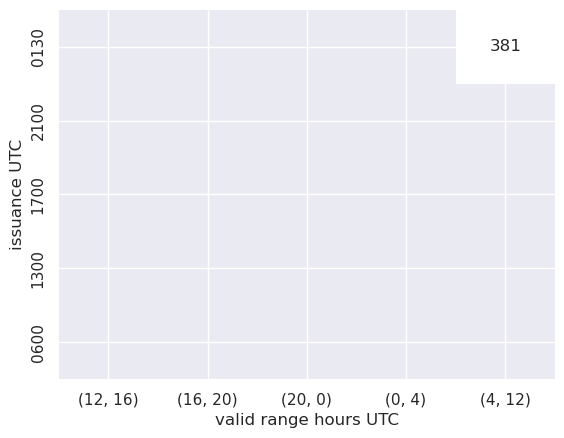

In [59]:
def plot_cnt(cnt, cmap=None):
    df = pd.DataFrame(
        cnt.index.tolist(),
        columns=["issuance UTC", "valid_start_hour", "valid_end_hour"],
    )
    df["valid range hours UTC"] = list(zip(df.valid_start_hour, df.valid_end_hour))
    df["n"] = cnt.values
    df = df.reset_index().pivot(
        columns="valid range hours UTC", index="issuance UTC", values="n"
    )
    df = df.reindex(
        ["0130", "2100", "1700", "1300", "0600"],
        columns=[(12, 16), (16, 20), (20, 0), (0, 4), (4, 12)],
    )
    g = sns.heatmap(df, annot=True, fmt="3.0f", cmap=cmap, cbar=False)
    return g


g = plot_cnt(
    cnt,
    cmap=mpl.colors.LinearSegmentedColormap.from_list(
        "cnt", ["white", fig.get_axes()[0].get_lines()[-1].get_color()]
    ),
)
ofile = tmpdir / "cnt.png"
plt.savefig(ofile)
logging.warning(ofile)

## Verify dense neural network forecast

In [60]:
ensmean.index.get_level_values("forecast_hour").unique()

Index([48, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype='int32', name='forecast_hour')

## Get obsvar at rptdist and twin from DNN obs and fcst
### Plot DNN performance at all valid times, regardless of SPC fcst

In [61]:
import sklearn
from shapely.geometry import Polygon

def statjob(group):
    logging.info(f"statjob: {group.name}")
    # seperate y_pred and labels and drop level 0
    y_pred = group.xs("y_pred", axis="columns", level=0)
    # labels went from bool to object dtype, so fix it or roc_auc_score will not recognize format
    labels = group.xs("y_label", axis="columns", level=0).astype(bool)

    bss = brier_skill_score(labels, y_pred)
    base_rate = labels.mean()
    # Default value is np.nan
    # Don't assign Series to auc and aps on same line or they will remain equal even if you change one
    auc = pd.Series(np.nan, index=labels.columns)
    aps = pd.Series(np.nan, index=labels.columns)
    # auc and aps require 2 unique labels, i.e. both True and False
    two = labels.nunique() == 2
    if two.any():
        # average=None returns a metric for each label instead of one group average of all labels
        auc[two] = sklearn.metrics.roc_auc_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
        aps[two] = sklearn.metrics.average_precision_score(
            labels.loc[:, two], y_pred.loc[:, two], average=None
        )
    n = y_pred.count()
    # geometry for geopandas dataframe
    forecast_hour, lat_bin, lon_bin = group.name
    poly = Polygon(
        (
            (lon_bin.left, lat_bin.left),
            (lon_bin.left, lat_bin.right),
            (lon_bin.right, lat_bin.right),
            (lon_bin.right, lat_bin.left),
        )
    )

    out = pd.DataFrame(
        dict(
            bss=bss,
            base_rate=base_rate,
            auc=auc,
            aps=aps,
            n=n,
            geometry=poly,
            forecast_hour=0.5 * (forecast_hour.left + forecast_hour.right),
        )
    )
    out.index.name = "class"
    return out

In [62]:
tqdm.pandas()
fhr_bin = pd.cut(ensmean.index.get_level_values("forecast_hour"), bins=range(0, 49, 1))
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=np.arange(25, 50, 2))
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=np.arange(-126, -64, 2))

by_llfhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
).progress_apply(statjob)

by_llfhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

100%|██████████| 11280/11280 [04:35<00:00, 40.91it/s]


In [63]:
import folium.plugins

m = folium.plugins.DualMap(location=[37, -95], zoom_start=3, layout="vertical")

s = fhr_bin.categories[8]  # pick a forecast hour bin
print(s)
gdf = geopandas.GeoDataFrame(
    by_llfhr.xs(f, level="class").xs(s, level="fhr_bin"), crs=ccrs.PlateCarree()
)
gdf.explore(
    column="bss",
    vmin=0.0,
    vmax=0.6,
    style_kwds={"fillOpacity": 0.8},
    cmap="Greens",
    m=m.m1,
)
gdf.explore(
    column="base_rate",
    vmin=0,
    vmax=0.05 * twin,
    style_kwds={"fillOpacity": 0.8},
    cmap="Purples",
    m=m.m2,
)

(8, 9]


In [64]:
lat_bin = pd.cut(ensmean.index.get_level_values("lat"), bins=1)
lon_bin = pd.cut(ensmean.index.get_level_values("lon"), bins=1)
by_fhr = ensmean.groupby(
    by=[fhr_bin, lat_bin, lon_bin],
    observed=True,
).progress_apply(statjob)

by_fhr.index.names = ("fhr_bin", "lat_bin", "lon_bin", "class")

100%|██████████| 48/48 [01:36<00:00,  2.01s/it]


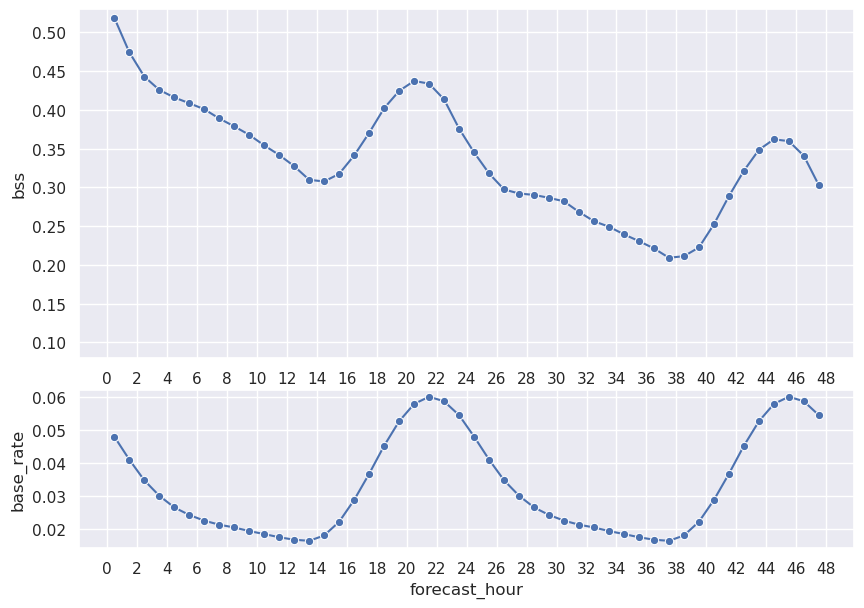

In [65]:
# Figure dimensions
fig = plt.figure(figsize=(10, 7))

topax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
botax = plt.subplot2grid((3, 1), (2, 0), rowspan=1, sharex=topax)
botax.xaxis.set_major_locator(ticker.MultipleLocator(2))

ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="bss",
    ax=topax,
    marker="o",
)
ax.set_ylim((0.08, 0.53))
ax = sns.lineplot(
    by_fhr.xs(f, level="class"),
    x="forecast_hour",
    y="base_rate",
    ax=botax,
    marker="o",
    legend=False,
)

In [66]:
fcst.index

MultiIndex([(12, 48, 'enh00_20201202_022000_202012020531-shp.zip'),
            (12, 49, 'enh00_20201202_022000_202012020531-shp.zip'),
            (12, 69, 'enh00_20201202_022000_202012020531-shp.zip'),
            (12, 70, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 47, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 48, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 69, 'enh00_20201202_022000_202012020531-shp.zip'),
            (13, 70, 'enh00_20201202_022000_202012020531-shp.zip'),
            (14, 47, 'enh00_20201202_022000_202012020531-shp.zip'),
            (14, 48, 'enh00_20201202_022000_202012020531-shp.zip'),
            ...
            (45, 33, 'enh20_20211231_311600_202112311237-shp.zip'),
            (45, 34, 'enh20_20211231_311600_202112311237-shp.zip'),
            (45, 35, 'enh20_20211231_311600_202112311237-shp.zip'),
            (45, 36, 'enh20_20211231_311600_202112311237-shp.zip'),
            (46, 23, 'enh20_2021

0.3581


2024-02-28 13:53:46,289 made /glade/derecho/scratch/ahijevyc/tmp/dnn.001+cg.ic.all.initialization_time.valid_time.y.x.forecast_hour.lat.lon.png


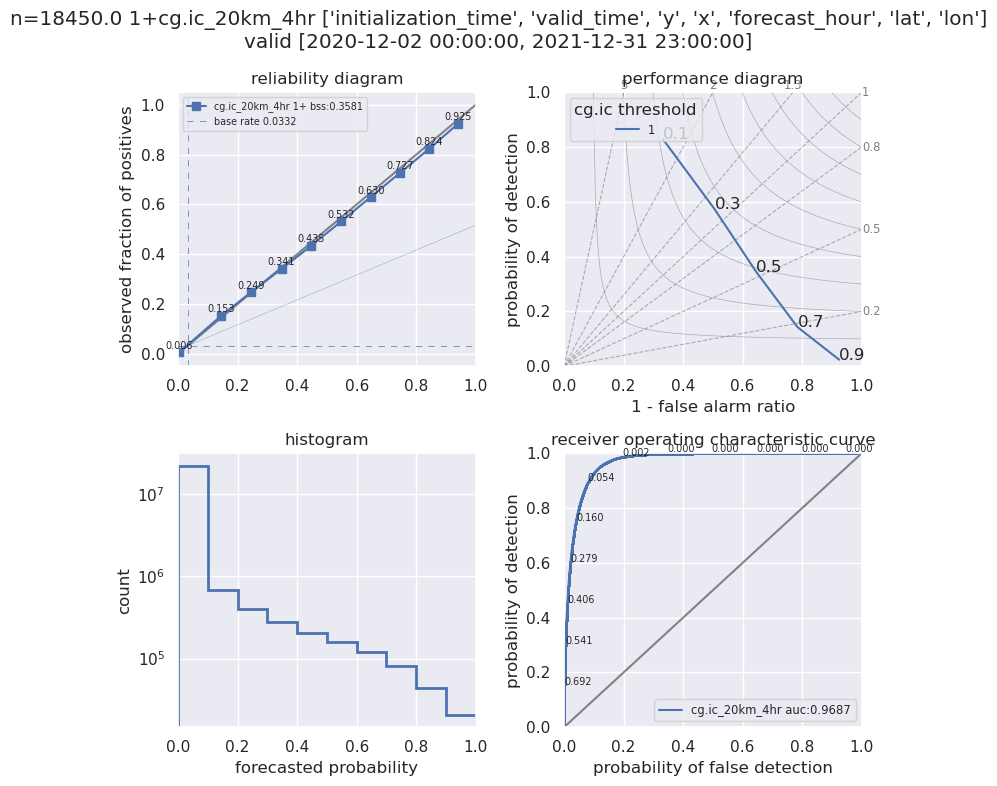

In [67]:
obs = ensmean.xs("y_label", axis="columns", level=0)
fcst = ensmean.xs("y_pred", axis="columns", level=0)
pthresh = pd.Series(np.round(np.arange(0.1, 1.1, 0.2), 2), name=f"fcst\np thresh")

valid_range_str = (
    f'[{ensmean.index.get_level_values("valid_time").min()},'
    f' {ensmean.index.get_level_values("valid_time").max()}]'
)

_ = stat_plots(
    obs[f],
    fcst[f],
    thresh=thresh,
    pthresh=pthresh,
    o_thresh_roc=o_thresh,
    sep=0.15,
    suptitle=f"n={len(ensmean)/1308} {o_thresh}+{f} {levels}\nvalid {valid_range_str}",
)
ofile = tmpdir / f"dnn.{o_thresh:03d}+{obsvar}.all.{'.'.join(levels)}.png"
plt.savefig(ofile)
logging.warning(f"made {ofile}")

## Restrict DNN to valid times of SPC forecast

In [68]:
def pprod(record, fcst=fcst):
    """
    Return DNN probability for the same valid range as
    an spc forecast record.
    Valid range may span consecutive time windows, each
    with an independent DNN probability.
    """
    s = record.name
    issue, valid_start, valid_end = get_issuance_time(s)
    dnntimes = pd.date_range(
        start=valid_start + pd.Timedelta(hours=twin / 2),
        end=valid_end - pd.Timedelta(hours=twin / 2),
        freq=f"{twin}H",
    )
    assert fcst.index.names[1] == "valid_time", "valid_time must be MultiIndex level 1"
    try:
        thisfcst = fcst.loc[(slice(None), dnntimes), :]
        # Probability of no occurences during multiple time windows
        # equals product of 1-p for each time window.
        prob_none = (1 - thisfcst).groupby(["y", "x"]).prod()
        # Probability of one or more occurrences is 1 minus that.
        p = 1 - prob_none
        return p
    except KeyError as err:
        logging.warning(f"{err} {s} {issue} [{valid_start},{valid_end}]")
    except:
        logging.error(f"pprod broke on {s} {issue} [{valid_start},{valid_end}]")
        sys.exit(1)


fhr_start = int(12 + twin / 2)
fhr_end = int(36 - twin / 2)
logging.warning(
    f"Limit forecast hour range [{fhr_start}, {fhr_end}], get ensemble mean"
)
# selected forecast hours only. drops level by default
fcst = fcst.xs(slice(fhr_start, fhr_end), level="forecast_hour")

pprod_par = tmpdir / f"ps.fhr{fhr_start}-{fhr_end}.{o_thresh:03d}+{platform}.par"
if not clobber and os.path.exists(pprod_par):
    logging.warning(f"use old dnn probability product output {pprod_par}")
    p = pd.read_parquet(pprod_par)
else:
    time0 = time.time()
    logging.warning(
        f"Save dnn probability for each spc forecast (i.e. record) to {pprod_par}"
    )
    tqdm.pandas()
    p = spc_fcst.groupby("record").progress_apply(pprod, fcst=fcst)
    p.to_parquet(pprod_par)
    print(time.time() - time0)

logging.warning(
    "get (issuance time, valid hours) from DNN forecasts matched to SPC records"
)
x = [get_issuance_time(s) for s in tqdm(p.index.get_level_values("record"))]
issue, valid_start, valid_end = map(np.array, zip(*x))

valid_start_hours = np.array([x.hour for x in valid_start])
valid_end_hours = np.array([x.hour for x in valid_end])

2024-02-28 13:53:47,413 Limit forecast hour range [14, 34], get ensemble mean
2024-02-28 13:53:48,168 use old dnn probability product output /glade/derecho/scratch/ahijevyc/tmp/ps.fhr14-34.001+wbug.par
2024-02-28 13:53:49,825 get (issuance time, valid hours) from DNN forecasts matched to SPC records
100%|██████████| 6058656/6058656 [01:45<00:00, 57366.65it/s]


## Get obs at DNN times
- verify, plot, overlay on SPC scores

n=383 1+cg.ic_20km_4hr [('0600', 12, 16)] 0.3101
n=357 1+cg.ic_20km_4hr [('0600', 16, 20)] 0.3696
n=412 1+cg.ic_20km_4hr [('1300', 16, 20)] 0.3729
n=362 1+cg.ic_20km_4hr [('0600', 20, 0)] 0.4339
n=403 1+cg.ic_20km_4hr [('1300', 20, 0)] 0.4342
n=396 1+cg.ic_20km_4hr [('1700', 20, 0)] 0.4341
n=380 1+cg.ic_20km_4hr [('1300', 0, 4)] 0.3174
n=389 1+cg.ic_20km_4hr [('1700', 0, 4)] 0.3176
n=398 1+cg.ic_20km_4hr [('2100', 0, 4)] 0.3189
n=374 1+cg.ic_20km_4hr [('1700', 4, 12)] 0.3345
n=397 1+cg.ic_20km_4hr [('2100', 4, 12)] 0.3377
n=381 1+cg.ic_20km_4hr [('0130', 4, 12)] 0.3372


2024-02-28 14:05:08,680 made /glade/derecho/scratch/ahijevyc/tmp/dnn.001+cg.ic_20km_4hr.png


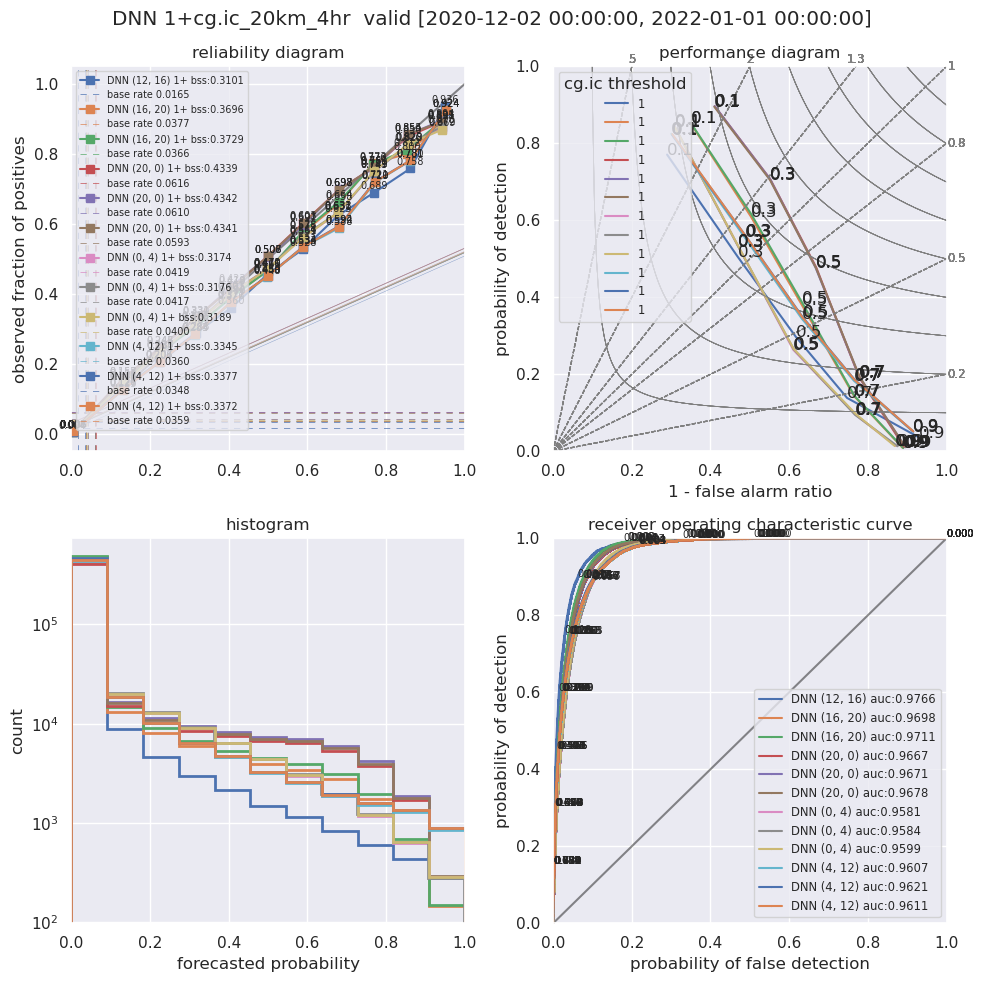

In [74]:
obs = spc_fcst.reorder_levels(p.index.names).loc[p.index, f]
fcst = p[f]

ztfs_func = partial(ztfs, how="floor")
#fcst = fcst.map(ztfs_func)  # round DNN probs to limited SPC prob levels

keep_SPC_fig = False
if not keep_SPC_fig:
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 5, nrows * 5))

dnn_bss = {}
for prodids in prodidss:
    iprodid = (
        pd.Series(list(zip(issue, valid_start_hours, valid_end_hours)))
        .isin(prodids)
        .values
    )
    print(f"n={iprodid.sum()/1308:.0f} {o_thresh}+{f} {prodids}", end=" ")

    ihr = spc_fcst.prodid.isin(prodids)
    assert ihr.sum()

    # Sanity check
    # DNN forecasts are missing when obsvar is missing in twin-h time window.
    # However there may be valid obsvar within longer valid time window of SPC forecast.
    # get_obs allows for missing obsvar. It just takes the mean of what is
    # available and then multiplies it by the total time window length.
    # e.g. you get a valid lightning count from
    # get_obs(pd.to_datetime("20210827T20"), pd.to_datetime("20210828T00"), obsvar, 2, rptdist)
    # but labels is missing for one of the 2-h components of that 4-hour SPC forecast valid time window.
    # labels.loc[("2021-08-27", "2021-08-27 21:00:00", 12, 48, slice(None))]
    missing_DNN_forecasts = set(spc_fcst[ihr].groupby("record").first().index) - set(
        p[iprodid].groupby("record").first().index
    )
    if len(missing_DNN_forecasts):
        logging.warning(f"{len(missing_DNN_forecasts)} missing DNN forecasts")
        print(missing_DNN_forecasts)

    missing_SPC_forecasts = set(p[iprodid].groupby("record").first().index) - set(
        spc_fcst[ihr].groupby("record").first().index
    )
    if len(missing_SPC_forecasts):
        logging.warning(f"{len(missing_SPC_forecasts)} missing SPC forecasts")
        print(missing_SPC_forecasts)



    thisf = fcst[iprodid]
    thisf.name = "DNN" + valid_hour_str(prodids)

    fig = stat_plots(
        obs[iprodid],
        thisf,
        thresh=thresh,
        pthresh=pthresh,
        o_thresh_roc=o_thresh,
        sep=0.15,
        n_bins=11,
        fig=fig,
    )
    if len(prodids) == 1:
        dnn_bss[prodids[0]] = brier_skill_score(obs[iprodid] >= o_thresh, thisf)

title = f"DNN {o_thresh}+{f}  valid [{valid_start.min()}, {valid_end.max()}]"
plt.suptitle(title, wrap=True)
plt.tight_layout()

ofile = tmpdir / f"dnn.{o_thresh:03d}+{f}.png"
fig.savefig(ofile)
logging.warning(f"made {ofile}")

2024-02-28 14:05:11,947 /glade/derecho/scratch/ahijevyc/tmp/barplot.png


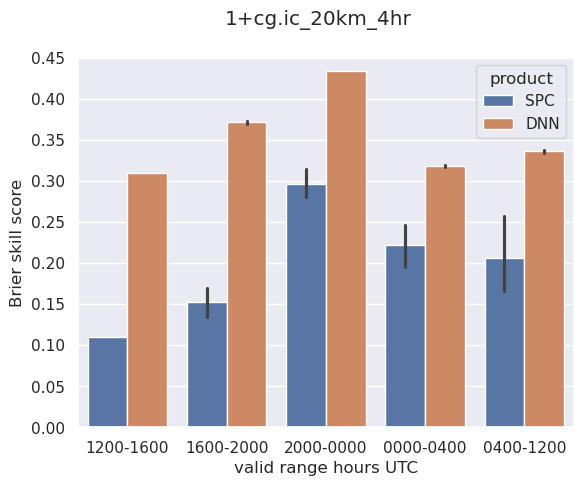

In [75]:
bss_df = pd.concat(
    [pd.Series(spc_bss, name="SPC"), pd.Series(dnn_bss, name="DNN")], axis="columns"
)
bss_df.index = pd.MultiIndex.from_tuples([(i, f"{j:02d}00-{k:02d}00") for i, j, k in bss_df.index])
valid_hr_str = "valid range hours UTC"
bss_df.index.names = ["issuance", valid_hr_str]
bss_df.columns.name = "product"
bss_df = bss_df.reset_index().melt(
    id_vars=["issuance", valid_hr_str], value_name="Brier skill score"
)

g = sns.barplot(data=bss_df, x=valid_hr_str, y="Brier skill score", hue="product")
g.set_ylim(0.0, 0.45)
plt.suptitle(f"{o_thresh}+{f}")

ofile = tmpdir / "barplot.png"
plt.savefig(ofile)
logging.warning(ofile)

2024-02-28 14:05:12,461 /glade/derecho/scratch/ahijevyc/tmp/1+cg.ic_20km_4hr.relplot.png


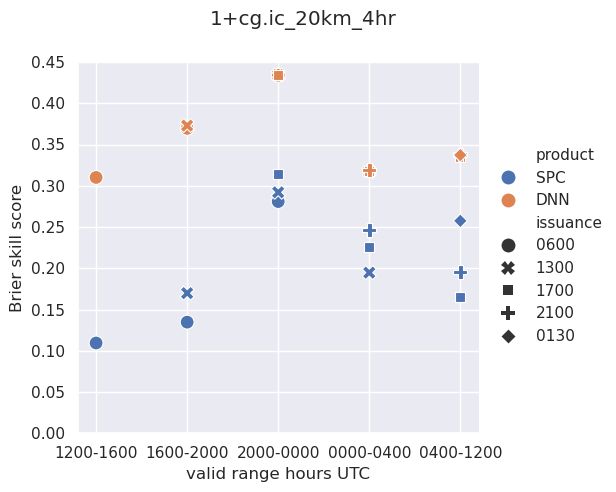

In [76]:
g = sns.relplot(
    bss_df,
    x=valid_hr_str,
    y="Brier skill score",
    hue="product",
    style="issuance",
    kind="scatter",
    s=100,
)
plt.suptitle(f"{o_thresh}+{f}")
g.set(ylim=(0.0, 0.45))
ofile = tmpdir / f"{o_thresh}+{f}.relplot.png"
plt.tight_layout(rect=[0, 0, 0.85, 1])
g.savefig(ofile)
logging.warning(ofile)

2024-02-28 14:05:12,927 /glade/derecho/scratch/ahijevyc/tmp/1+cg.ic_20km_4hr.heatplot.png


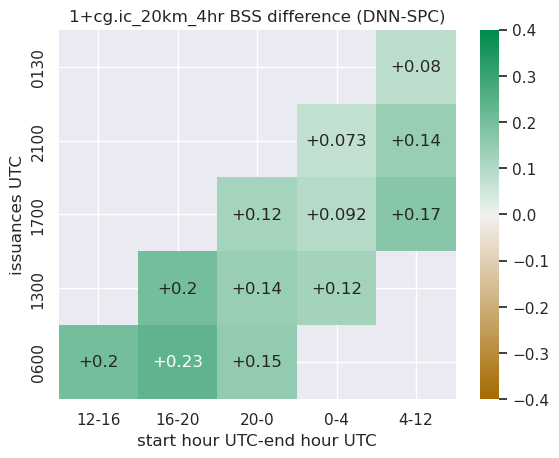

In [77]:
d = (
    (pd.Series(dnn_bss, name="DNN") - pd.Series(spc_bss, name="SPC"))
    .unstack(level=[1, 2])
    .reindex(["0130", "2100", "1700", "1300", "0600"])
)
d.index.name = "issuance UTC"
d.columns.names = ["start hour UTC", "end hour UTC"]

g = sns.heatmap(
    d,
    annot=True,
    vmin=-0.4,
    vmax=0.4,
    cmap=sns.diverging_palette(45, 140, s=100, as_cmap=True),
    fmt="+.2",
)
g.set_title(f"{o_thresh}+{f} BSS difference (DNN-SPC)")
ofile = tmpdir / f"{o_thresh}+{f}.heatplot.png"
plt.savefig(ofile)
logging.warning(ofile)